In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization , Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0,preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow.keras.utils as utils
import json


In [2]:
#nothing just rename files in order, why? idk
folder_path = 'E:\cycle_vs_bike\Dataset\scraped_cycle'
all_files = os.listdir(folder_path)

file_name = [i for i in all_files]

cnt = 1000
for i in file_name:
    name_parts = i.split('.')[0].split('_')
    name_parts[1] = str(cnt)
    new_name = '_'.join(name_parts) + '.' + i.split('.')[-1] 
    
    old_path = os.path.join(folder_path, i)
    new_path = os.path.join(folder_path, new_name)
        
    os.rename(old_path, new_path)
    cnt += 1
    

In [3]:
#transform images
cycle_list = []
dir_1 = 'E:\cycle_vs_bike\Dataset\scraped_cycle'
for i in os.listdir(dir_1):
    img = cv2.imread(dir_1+'/'+i) #take imgs one by one
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #bgr -> rgb
    img = cv2.resize(img, (224,224)) #this dim is req. for effecientnet
    cycle_list.append(img)

In [4]:
bike_list = []
dir_2 = 'E:\cycle_vs_bike\Dataset\scraped_bike'
for i in os.listdir(dir_2):
    img = cv2.imread(dir_2+'/'+i) #take imgs one by one
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #bgr -> rgb to plot in plt
    img = cv2.resize(img, (224,224)) #this dim is req. for effecientnet
    bike_list.append(img)

In [5]:
#preparing data
x_data = np.array(cycle_list + bike_list, dtype='float32')
y_data = np.array([0]*len(cycle_list) + [1]*len(bike_list))# 0 -> cycle, 1 -> bike 

x_data = preprocess_input(x_data) #normalize using EfficientNetB0 preprocess

In [6]:
x_data, y_data = shuffle(x_data, y_data, random_state=9) #shuffle it up

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.1  #10% split for val
)

train_aug = datagen.flow(x_data, y_data, batch_size=8, subset='training')
val_aug = datagen.flow(x_data, y_data, batch_size=8, subset='validation')

In [7]:
en = EfficientNetB0(include_top=False, input_shape=(224,224,3), weights='imagenet') #removes top layer for the classification
en.trainable = False #freez model for updating the weights

en.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [8]:
#add my custom layer on top of EfficientNetB0
model = Sequential([
    en,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

history = model.fit(
    train_aug,
    validation_data=val_aug,
    epochs=10,
    steps_per_epoch=max(1, len(train_aug)),
    validation_steps=max(1, len(val_aug)),
)

Epoch 1/10
23/23 [==============================] - 34s 821ms/step - loss: 0.5442 - accuracy: 0.7459 - val_loss: 0.2284 - val_accuracy: 0.9500
Epoch 2/10
23/23 [==============================] - 19s 828ms/step - loss: 0.2257 - accuracy: 0.9171 - val_loss: 0.1479 - val_accuracy: 0.9500
Epoch 3/10
23/23 [==============================] - 16s 685ms/step - loss: 0.1258 - accuracy: 0.9448 - val_loss: 0.1067 - val_accuracy: 0.9500
Epoch 4/10
23/23 [==============================] - 15s 672ms/step - loss: 0.1296 - accuracy: 0.9613 - val_loss: 0.0929 - val_accuracy: 0.9500
Epoch 5/10
23/23 [==============================] - 20s 861ms/step - loss: 0.0998 - accuracy: 0.9448 - val_loss: 0.0716 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 27s 1s/step - loss: 0.1268 - accuracy: 0.9613 - val_loss: 0.0562 - val_accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 19s 802ms/step - loss: 0.0520 - accuracy: 0.9779 - val_loss: 0.0468 - val_accuracy: 1.0000
Ep

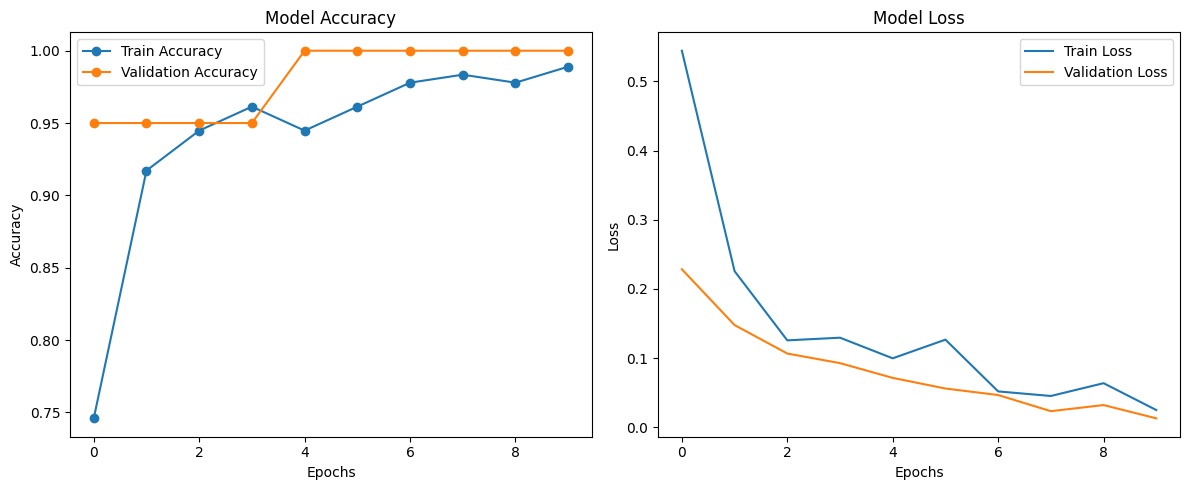

In [9]:
# Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [11]:
model.save_weights("cycle_vs_bike_weights.h5")

In [12]:
def predict_image(img_path, model, class_names=["cycle", "bike"]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = np.expand_dims(img, axis=0).astype('float32')
    
    img = preprocess_input(img)  
    
    # Predict
    preds = model.predict(img)
    confidence = np.max(preds) * 100
    predicted_class = class_names[np.argmax(preds)]
    
    print(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    return predicted_class, confidence


In [15]:
model.load_weights("cycle_vs_bike_weights.h5")
predict_image("E:/cycle_vs_bike/bike_test.png", model)

1/1 [==============================] - 4s 4s/step
Prediction: bike (94.55%)


('bike', 94.54982280731201)